In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2

# Dataset Preparation

In [3]:
batch_size = 32
img_height = 244
img_width = 244

In [4]:
data_dir = '/content/drive/MyDrive/DataSet Playing Cards'

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 521 files belonging to 10 classes.
Using 417 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 521 files belonging to 10 classes.
Using 104 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Ace', 'Eight', 'Five', 'Four', 'Nine', 'Seven', 'Six', 'Ten', 'Three', 'Two']


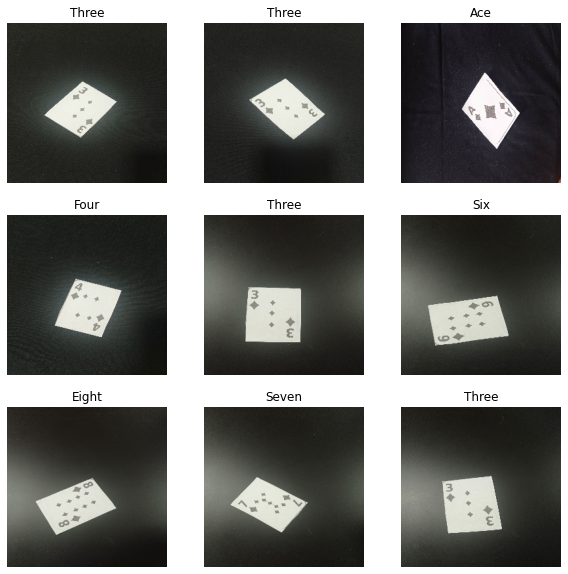

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 244, 244, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.024652893 0.91112185


# Model 1

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 244, 244, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 122, 122, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        1

In [15]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


14/14 [==============================] - 71s 5s/step - loss: 2.2756 - accuracy: 0.1487 - val_loss: 2.1492 - val_accuracy: 0.3365
Epoch 2/50
14/14 [==============================] - 22s 2s/step - loss: 1.9875 - accuracy: 0.2782 - val_loss: 1.9408 - val_accuracy: 0.3269
Epoch 3/50
14/14 [==============================] - 22s 2s/step - loss: 1.4071 - accuracy: 0.5468 - val_loss: 1.6146 - val_accuracy: 0.4904
Epoch 4/50
14/14 [==============================] - 22s 2s/step - loss: 0.8378 - accuracy: 0.7170 - val_loss: 1.8768 - val_accuracy: 0.4904
Epoch 5/50
14/14 [==============================] - 22s 2s/step - loss: 0.4900 - accuracy: 0.8369 - val_loss: 1.7619 - val_accuracy: 0.6058
Epoch 6/50
14/14 [==============================] - 22s 2s/step - loss: 0.3641 - accuracy: 0.9017 - val_loss: 2.1602 - val_accuracy: 0.6154
Epoch 7/50
14/14 [==============================] - 22s 2s/step - loss: 0.1825 - accuracy: 0.9520 - val_loss: 2.3292 - val_accuracy: 0.5865
Epoch 8/50
14/14 [=============

In [16]:
model.save('model_1.h5')

In [17]:
class_to_value = {'Ace': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5, 'Six': 6, 'Seven': 7, 'Eight': 8, 'Nine': 9, 'Ten': 10}
test_folder_path = '/content/drive/MyDrive/DataSet Playing Cards/Nine/'
card_sum = 0
for filename in os.listdir(test_folder_path):
  img = tf.keras.utils.load_img(
      os.path.join(test_folder_path, filename), target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = predictions[0]
  predicted_class = class_names[np.argmax(score)]
  predicted_value = class_to_value[predicted_class]
  card_sum += predicted_value
  accuracy = np.max(score) * 100
  print('predicted value is', predicted_value)
  print('accuracy', round(accuracy, 2))
  print('card sum is', card_sum)

predicted value is 9
accuracy 100.0
card sum is 9
predicted value is 9
accuracy 99.98
card sum is 18
predicted value is 9
accuracy 100.0
card sum is 27
predicted value is 9
accuracy 99.99
card sum is 36
predicted value is 9
accuracy 100.0
card sum is 45
predicted value is 9
accuracy 100.0
card sum is 54
predicted value is 9
accuracy 99.94
card sum is 63
predicted value is 9
accuracy 100.0
card sum is 72
predicted value is 9
accuracy 100.0
card sum is 81
predicted value is 9
accuracy 100.0
card sum is 90
predicted value is 9
accuracy 100.0
card sum is 99
predicted value is 9
accuracy 100.0
card sum is 108
predicted value is 9
accuracy 100.0
card sum is 117
predicted value is 9
accuracy 100.0
card sum is 126
predicted value is 9
accuracy 100.0
card sum is 135
predicted value is 9
accuracy 100.0
card sum is 144
predicted value is 9
accuracy 100.0
card sum is 153
predicted value is 9
accuracy 100.0
card sum is 162
predicted value is 9
accuracy 100.0
card sum is 171
predicted value is 9
acc

# Model 2

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


14/14 [==============================] - 135s 9s/step - loss: 2.3040 - accuracy: 0.0983 - val_loss: 2.2787 - val_accuracy: 0.1058
Epoch 2/50
14/14 [==============================] - 131s 9s/step - loss: 2.2889 - accuracy: 0.1487 - val_loss: 2.2950 - val_accuracy: 0.0962
Epoch 3/50
14/14 [==============================] - 131s 9s/step - loss: 2.2868 - accuracy: 0.1367 - val_loss: 2.2883 - val_accuracy: 0.0962
Epoch 4/50
14/14 [==============================] - 131s 9s/step - loss: 2.2856 - accuracy: 0.1367 - val_loss: 2.2937 - val_accuracy: 0.0962
Epoch 5/50
14/14 [==============================] - 132s 9s/step - loss: 2.2886 - accuracy: 0.1367 - val_loss: 2.2984 - val_accuracy: 0.0962
Epoch 6/50
14/14 [==============================] - 131s 9s/step - loss: 2.2895 - accuracy: 0.1391 - val_loss: 2.3047 - val_accuracy: 0.1346
Epoch 7/50
14/14 [==============================] - 131s 9s/step - loss: 2.2882 - accuracy: 0.1727 - val_loss: 2.2897 - val_accuracy: 0.1442
Epoch 8/50
14/14 [======

In [22]:
model.save('model_2.h5')

In [23]:
class_to_value = {'Ace': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5, 'Six': 6, 'Seven': 7, 'Eight': 8, 'Nine': 9, 'Ten': 10}
test_folder_path = '/content/drive/MyDrive/DataSet Playing Cards/Nine/'
card_sum = 0
for filename in os.listdir(test_folder_path):
  img = tf.keras.utils.load_img(
      os.path.join(test_folder_path, filename), target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = predictions[0]
  predicted_class = class_names[np.argmax(score)]
  predicted_value = class_to_value[predicted_class]
  card_sum += predicted_value
  accuracy = np.max(score) * 100
  print('predicted value is', predicted_value)
  print('accuracy', round(accuracy, 2))
  print('card sum is', card_sum)

predicted value is 9
accuracy 98.46
card sum is 9
predicted value is 9
accuracy 81.75
card sum is 18
predicted value is 9
accuracy 97.83
card sum is 27
predicted value is 4
accuracy 48.53
card sum is 31
predicted value is 9
accuracy 59.71
card sum is 40
predicted value is 9
accuracy 98.85
card sum is 49
predicted value is 7
accuracy 42.61
card sum is 56
predicted value is 9
accuracy 99.08
card sum is 65
predicted value is 9
accuracy 58.01
card sum is 74
predicted value is 9
accuracy 99.15
card sum is 83
predicted value is 9
accuracy 45.42
card sum is 92
predicted value is 9
accuracy 89.62
card sum is 101
predicted value is 9
accuracy 98.99
card sum is 110
predicted value is 9
accuracy 96.49
card sum is 119
predicted value is 9
accuracy 99.23
card sum is 128
predicted value is 9
accuracy 97.24
card sum is 137
predicted value is 9
accuracy 98.64
card sum is 146
predicted value is 7
accuracy 51.89
card sum is 153
predicted value is 9
accuracy 95.83
card sum is 162
predicted value is 9
acc

# Model 3

In [24]:
from tensorflow.keras.applications.vgg16 import VGG16

In [25]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False ## Not trainable weights
model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1605696   
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 10)                330       
                                                                 
Total params: 16,322,794
Trainable params: 1,608,106
Non-trainable params: 14,714,688
___________________________________

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
14/14 [==============================] - 271s 20s/step - loss: 0.0890 - accuracy: 0.9880 - val_loss: 0.7738 - val_accuracy: 0.8462
Epoch 2/10
14/14 [==============================] - 271s 20s/step - loss: 0.0503 - accuracy: 0.9976 - val_loss: 0.7085 - val_accuracy: 0.8558
Epoch 3/10
14/14 [==============================] - 272s 20s/step - loss: 0.0326 - accuracy: 1.0000 - val_loss: 0.6933 - val_accuracy: 0.8654
Epoch 4/10
14/14 [==============================] - 271s 20s/step - loss: 0.0251 - accuracy: 1.0000 - val_loss: 0.6919 - val_accuracy: 0.8558
Epoch 5/10
14/14 [==============================] - 272s 20s/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 0.6891 - val_accuracy: 0.8558
Epoch 6/10
14/14 [==============================] - 271s 20s/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.6902 - val_accuracy: 0.8558
Epoch 7/10
14/14 [==============================] - 271s 21s/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.6817 - val_accuracy: 0.8558
Epoch 

In [ ]:
model.save('model_3.h5')

In [29]:
class_to_value = {'Ace': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5, 'Six': 6, 'Seven': 7, 'Eight': 8, 'Nine': 9, 'Ten': 10}
test_folder_path = '/content/drive/MyDrive/DataSet Playing Cards/Ten/'
card_sum = 0
for filename in os.listdir(test_folder_path):
  img = tf.keras.utils.load_img(
      os.path.join(test_folder_path, filename), target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = predictions[0]
  predicted_class = class_names[np.argmax(score)]
  predicted_value = class_to_value[predicted_class]
  card_sum += predicted_value
  accuracy = np.max(score) * 100
  print('predicted value is', predicted_value)
  print('accuracy', round(accuracy, 2))
  print('card sum is', card_sum)

predicted value is 10
accuracy 99.7
card sum is 10
predicted value is 10
accuracy 99.99
card sum is 20
predicted value is 10
accuracy 99.9
card sum is 30
predicted value is 10
accuracy 99.85
card sum is 40
predicted value is 10
accuracy 99.94
card sum is 50
predicted value is 10
accuracy 99.95
card sum is 60
predicted value is 10
accuracy 99.92
card sum is 70
predicted value is 10
accuracy 99.77
card sum is 80
predicted value is 10
accuracy 99.91
card sum is 90
predicted value is 10
accuracy 99.96
card sum is 100
predicted value is 10
accuracy 99.24
card sum is 110
predicted value is 10
accuracy 99.93
card sum is 120
predicted value is 10
accuracy 99.82
card sum is 130
predicted value is 10
accuracy 99.99
card sum is 140
predicted value is 10
accuracy 94.97
card sum is 150
predicted value is 3
accuracy 58.1
card sum is 153
predicted value is 1
accuracy 81.94
card sum is 154
predicted value is 10
accuracy 96.45
card sum is 164
predicted value is 10
accuracy 99.99
card sum is 174
predict